<a href="https://colab.research.google.com/github/singhm8755/Machinelearning_Project/blob/main/ML_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===================================================================
# INSTALLATION & IMPORTS
# Based on: Lecture 1-10, scikit-learn documentation
# ===================================================================

# Install required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Algorithms (from course materials)
from sklearn.tree import DecisionTreeClassifier  # Lecture 1
from sklearn.neighbors import KNeighborsClassifier  # Lecture 2
from sklearn.naive_bayes import CategoricalNB, GaussianNB  # Lecture 8
from sklearn.svm import SVC  # Lecture 7
from sklearn.ensemble import RandomForestClassifier  # Lecture 9 (Ensemble Learning)

# Evaluation Metrics
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve
)

# Handling Class Imbalance (Lecture 9)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("libraries installed successfully")

libraries installed successfully


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ===================================================================
# SECTION 1.1: DATA LOADING & EXPLORATION
# ===================================================================

# Load datasets

df_attributes = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Attribute_DataSet.xlsx')
df_sales = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dress_Sales.xlsx')

print("Datasets Loaded successfully")

Datasets Loaded successfully


In [ ]:

print(f"Dataset shape: {df_attributes.shape}")
print(f"\nColumn names and types:\n")
print(df_attributes.dtypes)
print(f"\nTarget variable distribution:")
print(df_attributes['Recommendation'].value_counts())
print(f"\nMissing data analysis:")
missing_data = df_attributes.isnull().sum()
missing_percent = (missing_data / len(df_attributes)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False))

Dataset shape: (500, 14)

Column names and types:

Dress_ID            int64
Style              object
Price              object
Rating            float64
Size               object
Season             object
NeckLine           object
SleeveLength       object
waiseline          object
Material           object
FabricType         object
Decoration         object
Pattern Type       object
Recommendation      int64
dtype: object

Target variable distribution:
Recommendation
0    290
1    210
Name: count, dtype: int64

Missing data analysis:
          Column  Missing_Count  Missing_Percentage
10    FabricType            266                53.2
11    Decoration            236                47.2
9       Material            128                25.6
12  Pattern Type            109                21.8
8      waiseline             87                17.4
6       NeckLine              3                 0.6
2          Price              2                 0.4
7   SleeveLength              2          

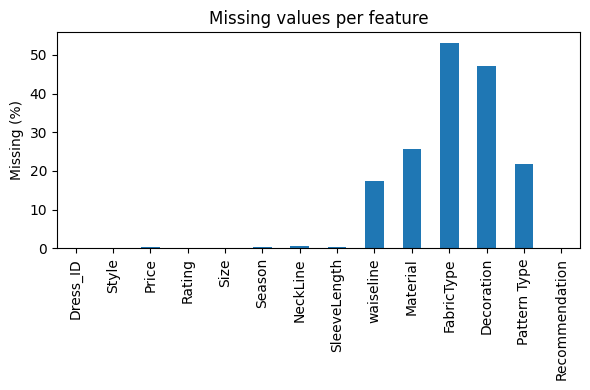

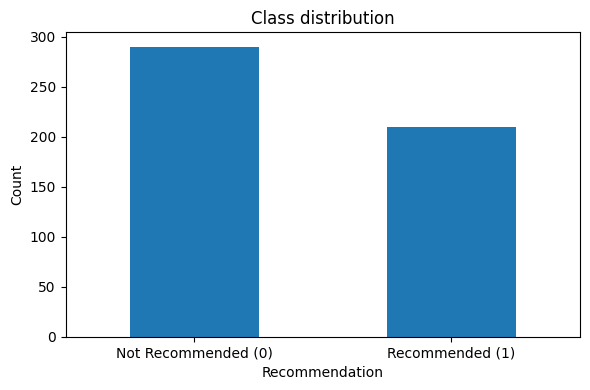

Class imbalance ratio (0:1) = 1.38:1


In [ ]:
# ===================================================================
# SECTION 1.2: EXPLORATORY DATA ANALYSIS (EDA)
# ===================================================================


# ---- Missing data ----
plt.figure(figsize=(6, 4))
(df_attributes.isnull().mean() * 100).plot(kind='bar')
plt.ylabel('Missing (%)')
plt.title('Missing values per feature')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# ---- Target variable distribution ----
plt.figure(figsize=(6, 4))
df_attributes['Recommendation'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Not Recommended (0)', 'Recommended (1)'], rotation=0)
plt.ylabel('Count')
plt.title('Class distribution')
plt.tight_layout()
plt.show()

# Print simple imbalance ratio
recommendation_counts = df_attributes['Recommendation'].value_counts()
ratio = recommendation_counts[0] / recommendation_counts[1]
print(f"Class imbalance ratio (0:1) = {ratio:.2f}:1")

In [ ]:
# ===================================================================
# SECTION 1.3: DATA PREPROCESSING & FEATURE ENGINEERING
# (Lecture 6: Feature Reduction & Extraction)
# ===================================================================

# Create a copy for preprocessing
df_clean = df_attributes.copy()

# Step 1: Handle Missing Data (Lecture 9: Missing Data Solutions)
print("MISSING DATA HANDLING STRATEGY (Lecture 9)")
print("="*70)

# Categorical columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
numerical_cols = ['Rating']

print(f"\nCategorical features: {categorical_cols}")
print(f"Numerical features: {numerical_cols}")

# For categorical: Mode imputation (most frequent value)
for col in categorical_cols:
    mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
    df_clean[col].fillna(mode_val, inplace=True)
    print(f"  ✓ {col}: Imputed with mode = '{mode_val}'")

# For numerical: Mean imputation
df_clean['Rating'].fillna(df_clean['Rating'].mean(), inplace=True)
print(f"  ✓ Rating: Imputed with mean = {df_clean['Rating'].mean():.2f}")

print(f"\nVerification - Missing values after imputation:")
print(df_clean.isnull().sum().sum(), "missing values remaining")

# Step 2: Encode Categorical Variables
print("\n" + "="*70)
print("CATEGORICAL ENCODING")
print("="*70)

label_encoders = {}
categorical_features = ['Style', 'Price', 'Size', 'Season', 'NeckLine',
                        'SleeveLength', 'waiseline', 'Material',
                        'FabricType', 'Decoration', 'Pattern Type']

for col in categorical_features:
    le = LabelEncoder()
    df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ {col}: {len(le.classes_)} unique values encoded")

# Drop original categorical columns
df_processed = df_clean.drop(columns=['Dress_ID'] + categorical_features)
print(f"\nFinal feature set: {df_processed.shape[1]} features")
print(f"Features: {list(df_processed.columns)}")


MISSING DATA HANDLING STRATEGY (Lecture 9)

Categorical features: ['Style', 'Price', 'Size', 'Season', 'NeckLine', 'SleeveLength', 'waiseline', 'Material', 'FabricType', 'Decoration', 'Pattern Type']
Numerical features: ['Rating']
  ✓ Style: Imputed with mode = 'Casual'
  ✓ Price: Imputed with mode = 'Average'
  ✓ Size: Imputed with mode = 'M'
  ✓ Season: Imputed with mode = 'Summer'
  ✓ NeckLine: Imputed with mode = 'o-neck'
  ✓ SleeveLength: Imputed with mode = 'sleevless'
  ✓ waiseline: Imputed with mode = 'natural'
  ✓ Material: Imputed with mode = 'cotton'
  ✓ FabricType: Imputed with mode = 'chiffon'
  ✓ Decoration: Imputed with mode = 'lace'
  ✓ Pattern Type: Imputed with mode = 'solid'
  ✓ Rating: Imputed with mean = 3.53

Verification - Missing values after imputation:
0 missing values remaining

CATEGORICAL ENCODING
  ✓ Style: 13 unique values encoded
  ✓ Price: 7 unique values encoded
  ✓ Size: 7 unique values encoded
  ✓ Season: 8 unique values encoded
  ✓ NeckLine: 16 uniq

/tmp/ipython-input-3302271945.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(mode_val, inplace=True)
/tmp/ipython-input-3302271945.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:

# ===================================================================
# SECTION 1.4: DATA SPLITTING & STANDARDIZATION
# ===================================================================

# Separate features and target
X = df_processed.drop(columns=['Recommendation'])
y = df_processed['Recommendation']

print("DATA SPLITTING")
print("="*70)
print(f"Total samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"Target distribution: \n{y.value_counts()}")

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTrain set class distribution:\n{y_train.value_counts()}")
print(f"\nTest set class distribution:\n{y_test.value_counts()}")

# Standardization (Lecture 2: Data Normalisation for KNN)
print("\n" + "="*70)
print("FEATURE STANDARDIZATION (Lecture 2: KNN requires normalized data)")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"✓ Features standardized (mean=0, std=1)")
print(f"  Mean of scaled training data: {X_train_scaled.mean().mean():.6f}")
print(f"  Std of scaled training data: {X_train_scaled.std().mean():.6f}")
print(f"  Mean of scaled test data: {X_test_scaled.mean().mean():.6f}")



DATA SPLITTING
Total samples: 500
Features: 12
Target distribution: 
Recommendation
0    290
1    210
Name: count, dtype: int64

Train set: 400 samples (80.0%)
Test set: 100 samples (20.0%)

Train set class distribution:
Recommendation
0    232
1    168
Name: count, dtype: int64

Test set class distribution:
Recommendation
0    58
1    42
Name: count, dtype: int64

FEATURE STANDARDIZATION (Lecture 2: KNN requires normalized data)
✓ Features standardized (mean=0, std=1)
  Mean of scaled training data: 0.000000
  Std of scaled training data: 1.001252
  Mean of scaled test data: -0.035668


In [ ]:
# PCA Feature Reduction (Lecture 6)
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"PCA: {X_train.shape[1]} → {X_train_pca.shape[1]} features (95% var: {pca.explained_variance_ratio_.sum():.1%})")
print("Explained variance per PC:", pca.explained_variance_ratio_[:8])  # Top 8

PCA: 12 → 12 features (95% var: 100.0%)
Explained variance per PC: [0.11219792 0.10743083 0.10195013 0.09296063 0.09151735 0.08638577
 0.08484789 0.07594916]


In [ ]:
## SECTION 2: ALGORITHM IMPLEMENTATION (5 ALGORITHMS)

# ===================================================================
# SECTION 2.1: DECISION TREE CLASSIFIER (Lecture 1)
# ===================================================================
print("\n" + "="*70)
print("ALGORITHM 1: DECISION TREE CLASSIFIER (Lecture 1)")
print("="*70)

# Decision Tree with hyperparameter tuning
dt_params = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train, y_train)

print(f"✓ Decision Tree trained (Lecture 1: Understanding Decision Trees)")
print(f"  Best parameters: {dt_grid.best_params_}")
print(f"  Best CV F1-Score: {dt_grid.best_score_:.4f}")

dt_best = dt_grid.best_estimator_
dt_pred_train = dt_best.predict(X_train)
dt_pred_test = dt_best.predict(X_test)




ALGORITHM 1: DECISION TREE CLASSIFIER (Lecture 1)
✓ Decision Tree trained (Lecture 1: Understanding Decision Trees)
  Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
  Best CV F1-Score: 0.5156


In [ ]:

# ===================================================================
# SECTION 2.2: K-NEAREST NEIGHBORS (Lecture 2)
# ===================================================================
print("\n" + "="*70)
print("ALGORITHM 2: K-NEAREST NEIGHBORS (Lecture 2)")
print("="*70)

# KNN with hyperparameter tuning
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)  # KNN uses scaled features (Lecture 2)

print(f"✓ KNN trained (Lecture 2: Data Normalisation - scaled features used)")
print(f"  Best parameters: {knn_grid.best_params_}")
print(f"  Best CV F1-Score: {knn_grid.best_score_:.4f}")

knn_best = knn_grid.best_estimator_
knn_pred_train = knn_best.predict(X_train_scaled)
knn_pred_test = knn_best.predict(X_test_scaled)




ALGORITHM 2: K-NEAREST NEIGHBORS (Lecture 2)
✓ KNN trained (Lecture 2: Data Normalisation - scaled features used)
  Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
  Best CV F1-Score: 0.4487


In [ ]:
# ===================================================================
# SECTION 2.3: NAIVE BAYES CLASSIFIER (Lecture 8)
# ===================================================================
print("\n" + "="*70)
print("ALGORITHM 3: NAIVE BAYES CLASSIFIER (Lecture 8)")
print("="*70)

# Gaussian Naive Bayes (for continuous features)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

print(f"✓ Naive Bayes trained (Lecture 8: Probability-based classification)")
print(f"  Model converged successfully")
print(f"  Training accuracy: {nb_model.score(X_train, y_train):.4f}")

nb_pred_train = nb_model.predict(X_train)
nb_pred_test = nb_model.predict(X_test)



ALGORITHM 3: NAIVE BAYES CLASSIFIER (Lecture 8)
✓ Naive Bayes trained (Lecture 8: Probability-based classification)
  Model converged successfully
  Training accuracy: 0.6150


In [ ]:

# ===================================================================
# SECTION 2.4: SUPPORT VECTOR MACHINE (Lecture 7)
# ===================================================================
print("\n" + "="*70)
print("ALGORITHM 4: SUPPORT VECTOR MACHINE (Lecture 7)")
print("="*70)

# SVM with hyperparameter tuning
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
svm_grid = GridSearchCV(svm_model, svm_params, cv=5, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)  # SVM uses scaled features

print(f"✓ SVM trained (Lecture 7: Support Vector Machines)")
print(f"  Best parameters: {svm_grid.best_params_}")
print(f"  Best CV F1-Score: {svm_grid.best_score_:.4f}")

svm_best = svm_grid.best_estimator_
svm_pred_train = svm_best.predict(X_train_scaled)
svm_pred_test = svm_best.predict(X_test_scaled)



ALGORITHM 4: SUPPORT VECTOR MACHINE (Lecture 7)
✓ SVM trained (Lecture 7: Support Vector Machines)
  Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
  Best CV F1-Score: 0.5577


In [ ]:
# ===================================================================
# SECTION 2.5: RANDOM FOREST (Ensemble Learning - Lecture 9)
# ===================================================================
print("\n" + "="*70)
print("ALGORITHM 5: RANDOM FOREST (Ensemble Learning - Lecture 9)")
print("="*70)

# Random Forest with hyperparameter tuning
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"✓ Random Forest trained (Lecture 9: Ensemble Learning Methods)")
print(f"  Best parameters: {rf_grid.best_params_}")
print(f"  Best CV F1-Score: {rf_grid.best_score_:.4f}")

rf_best = rf_grid.best_estimator_
rf_pred_train = rf_best.predict(X_train)
rf_pred_test = rf_best.predict(X_test)

# Feature Importance Analysis (Lecture 6: Feature Reduction)
print("\nFeature Importance Analysis (Lecture 6: Feature Reduction)")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10))




ALGORITHM 5: RANDOM FOREST (Ensemble Learning - Lecture 9)
✓ Random Forest trained (Lecture 9: Ensemble Learning Methods)
  Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
  Best CV F1-Score: 0.5177

Feature Importance Analysis (Lecture 6: Feature Reduction)
                 Feature  Importance
0                 Rating    0.154011
4         Season_encoded    0.114628
1          Style_encoded    0.105416
6   SleeveLength_encoded    0.092091
8       Material_encoded    0.091242
5       NeckLine_encoded    0.081741
10    Decoration_encoded    0.077412
3           Size_encoded    0.073783
2          Price_encoded    0.071176
11  Pattern Type_encoded    0.061547


In [ ]:
# ===================================================================
# SECTION 2.6: HANDLING CLASS IMBALANCE WITH SMOTE (Lecture 9)
# ===================================================================
print("\n" + "="*70)
print("CLASS IMBALANCE HANDLING: SMOTE (Lecture 9)")
print("="*70)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE:")
print(f"  Class 0: {(y_train == 0).sum()} samples")
print(f"  Class 1: {(y_train == 1).sum()} samples")
print(f"\nAfter SMOTE:")
print(f"  Class 0: {(y_train_smote == 0).sum()} samples")
print(f"  Class 1: {(y_train_smote == 1).sum()} samples")

# Retrain models with SMOTE-balanced data
dt_smote = DecisionTreeClassifier(**dt_grid.best_params_, class_weight='balanced', random_state=42)
dt_smote.fit(X_train_smote, y_train_smote)
dt_smote_pred_test = dt_smote.predict(X_test)

rf_smote = RandomForestClassifier(**rf_grid.best_params_, class_weight='balanced', random_state=42, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
rf_smote_pred_test = rf_smote.predict(X_test)

print(f"✓ Models retrained with SMOTE-balanced training data")





CLASS IMBALANCE HANDLING: SMOTE (Lecture 9)
Before SMOTE:
  Class 0: 232 samples
  Class 1: 168 samples

After SMOTE:
  Class 0: 232 samples
  Class 1: 232 samples
✓ Models retrained with SMOTE-balanced training data


In [ ]:
## SECTION 3: COMPREHENSIVE MODEL EVALUATION

# ===================================================================
# SECTION 3.1: EVALUATION METRICS FUNCTION
# ===================================================================

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Comprehensive evaluation metrics calculation
    Based on: Lecture course evaluation methodologies
    """
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    roc_auc = None
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_pred_proba)
        except:
            roc_auc = None

    # Sensitivity and Specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp
    }

    return results, cm

print("Evaluation function defined successfully")




Evaluation function defined successfully


In [ ]:
# ===================================================================
# SECTION 3.2: EVALUATE ALL MODELS ON TEST SET
# ===================================================================
print("\n" + "="*70)
print("MODEL EVALUATION ON TEST SET")
print("="*70)

results_list = []

# Decision Tree
dt_results, dt_cm = evaluate_model(y_test, dt_best.predict(X_test),
                                   dt_best.predict_proba(X_test)[:, 1],
                                   "Decision Tree")
results_list.append(dt_results)

# KNN
knn_results, knn_cm = evaluate_model(y_test, knn_best.predict(X_test_scaled),
                                     knn_best.predict_proba(X_test_scaled)[:, 1],
                                     "KNN")
results_list.append(knn_results)

# Naive Bayes
nb_results, nb_cm = evaluate_model(y_test, nb_model.predict(X_test),
                                   nb_model.predict_proba(X_test)[:, 1],
                                   "Naive Bayes")
results_list.append(nb_results)

# SVM
svm_results, svm_cm = evaluate_model(y_test, svm_best.predict(X_test_scaled),
                                     svm_best.predict_proba(X_test_scaled)[:, 1],
                                     "SVM")
results_list.append(svm_results)

# Random Forest
rf_results, rf_cm = evaluate_model(y_test, rf_best.predict(X_test),
                                   rf_best.predict_proba(X_test)[:, 1],
                                   "Random Forest")
results_list.append(rf_results)

# Decision Tree with SMOTE
dt_smote_results, dt_smote_cm = evaluate_model(y_test, dt_smote.predict(X_test),
                                               dt_smote.predict_proba(X_test)[:, 1],
                                               "Decision Tree (SMOTE)")
results_list.append(dt_smote_results)

# Random Forest with SMOTE
rf_smote_results, rf_smote_cm = evaluate_model(y_test, rf_smote.predict(X_test),
                                               rf_smote.predict_proba(X_test)[:, 1],
                                               "Random Forest (SMOTE)")
results_list.append(rf_smote_results)

# Create results DataFrame
evaluation_df = pd.DataFrame(results_list)
print("\n" + evaluation_df.to_string(index=False))




MODEL EVALUATION ON TEST SET

                Model  Accuracy  Precision   Recall  Sensitivity  Specificity  F1-Score  ROC-AUC  TN  FP  FN  TP
        Decision Tree      0.53   0.446809 0.500000     0.500000     0.551724  0.471910 0.556856  32  26  21  21
                  KNN      0.53   0.435897 0.404762     0.404762     0.620690  0.419753 0.535304  36  22  25  17
          Naive Bayes      0.56   0.461538 0.285714     0.285714     0.758621  0.352941 0.543514  44  14  30  12
                  SVM      0.52   0.448276 0.619048     0.619048     0.448276  0.520000 0.520525  26  32  16  26
        Random Forest      0.54   0.437500 0.333333     0.333333     0.689655  0.378378 0.573481  40  18  28  14
Decision Tree (SMOTE)      0.58   0.500000 0.500000     0.500000     0.637931  0.500000 0.591954  37  21  21  21
Random Forest (SMOTE)      0.56   0.470588 0.380952     0.380952     0.689655  0.421053 0.568966  40  18  26  16


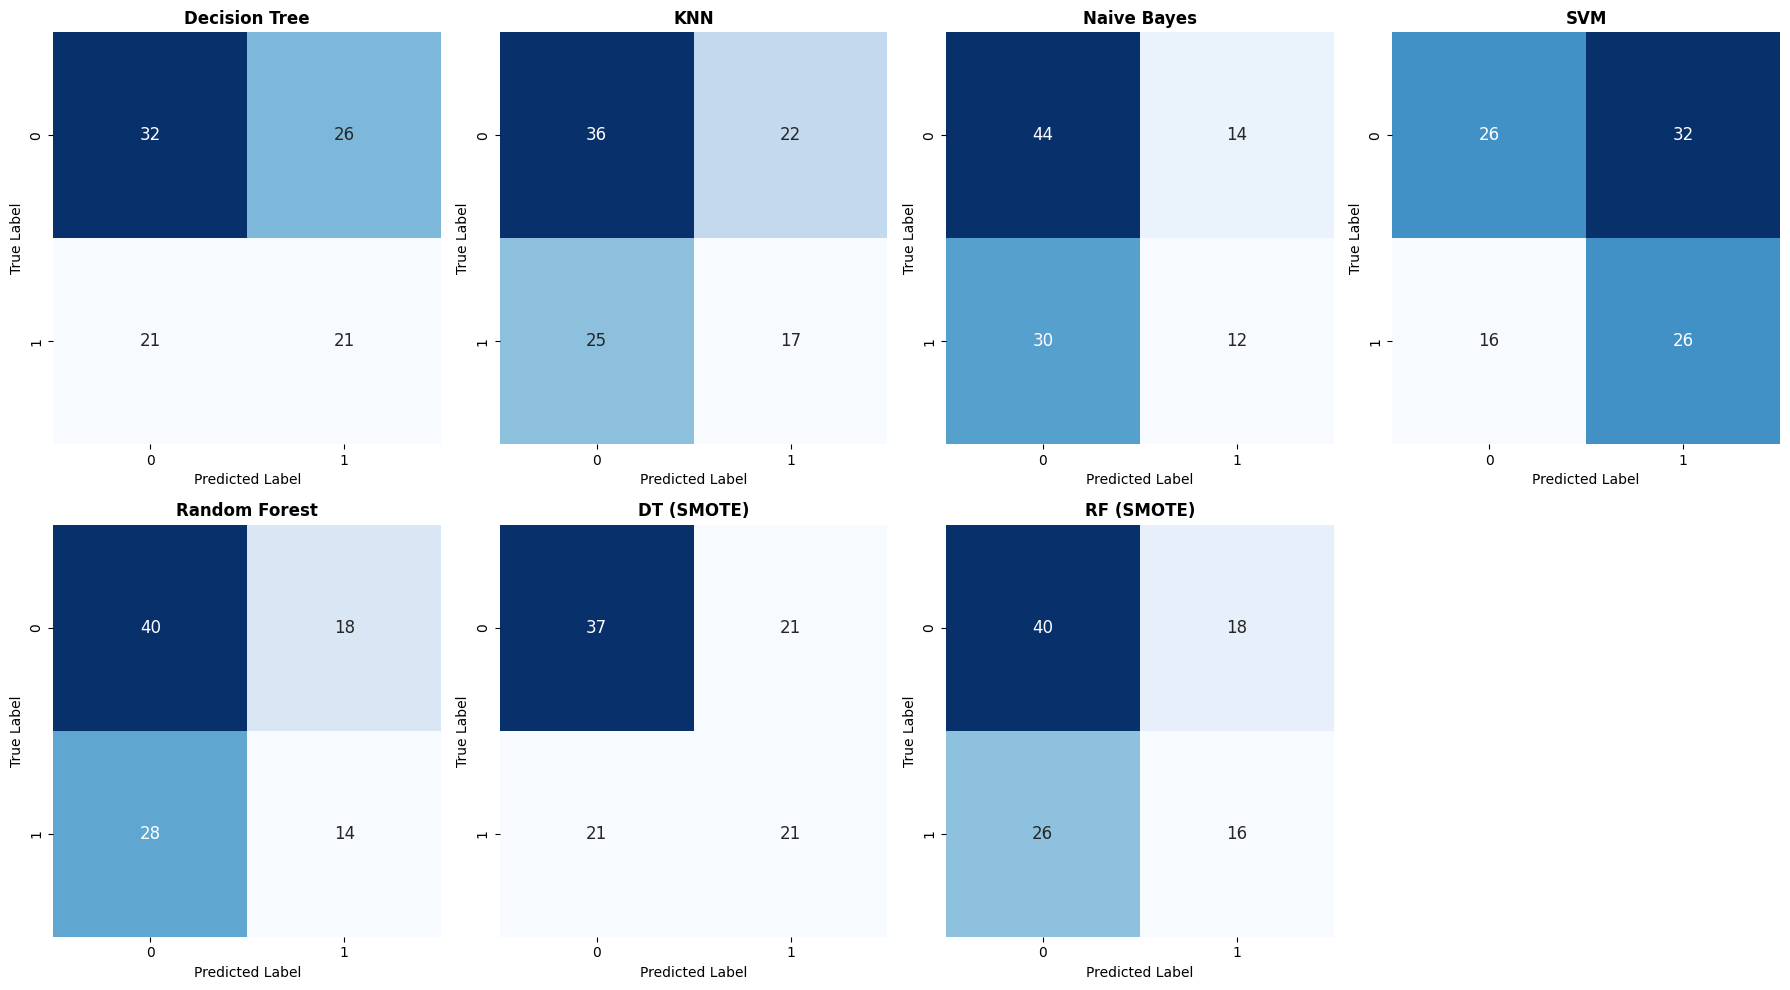

In [ ]:
# ===================================================================
# SECTION 3.3: CONFUSION MATRICES VISUALIZATION
# ===================================================================

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

confusions = [
    (dt_cm, "Decision Tree"),
    (knn_cm, "KNN"),
    (nb_cm, "Naive Bayes"),
    (svm_cm, "SVM"),
    (rf_cm, "Random Forest"),
    (dt_smote_cm, "DT (SMOTE)"),
    (rf_smote_cm, "RF (SMOTE)"),
]

for idx, (cm, title) in enumerate(confusions):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar=False, annot_kws={'size': 12})
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_xticklabels(['0', '1'])
    axes[idx].set_yticklabels(['0', '1'])

axes[7].axis('off')
plt.tight_layout()
plt.show()



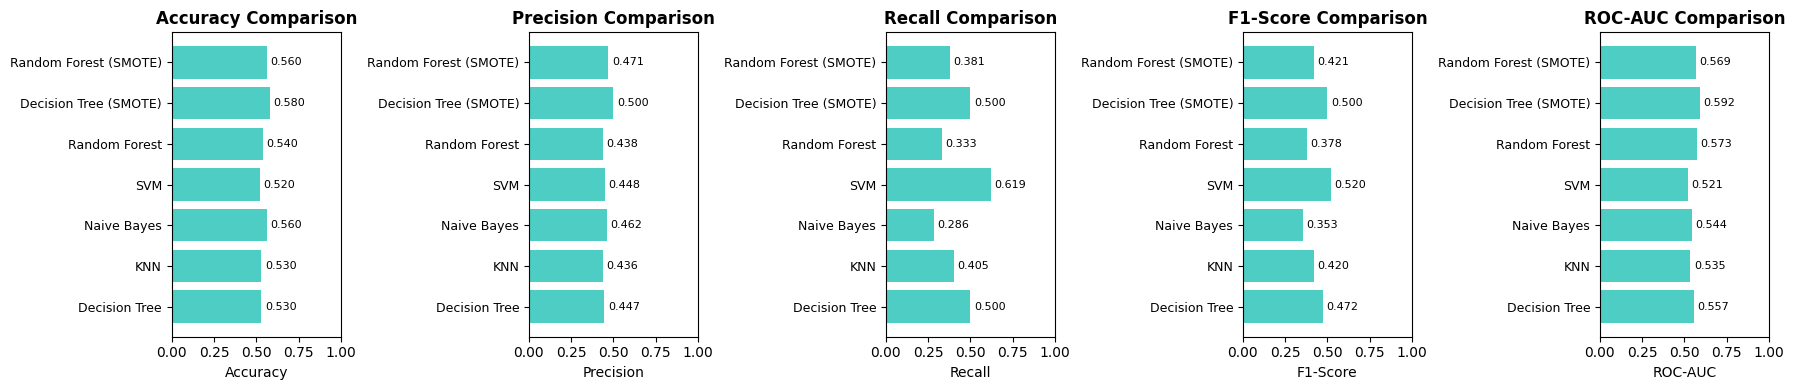

In [ ]:
# ===================================================================
# SECTION 3.4: PERFORMANCE METRICS COMPARISON
# ===================================================================

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for idx, metric in enumerate(metrics_to_plot):
    data = evaluation_df[['Model', metric]].dropna()
    colors = ['#FF6B6B' if metric == 'ROC-AUC' and val < 0.5 else '#4ECDC4'
              for val in data[metric]]

    axes[idx].barh(range(len(data)), data[metric].values, color='#4ECDC4')
    axes[idx].set_yticks(range(len(data)))
    axes[idx].set_yticklabels(data['Model'].values, fontsize=9)
    axes[idx].set_xlabel(metric)
    axes[idx].set_title(f'{metric} Comparison', fontweight='bold')
    axes[idx].set_xlim(0, 1)

    for i, v in enumerate(data[metric].values):
        axes[idx].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()



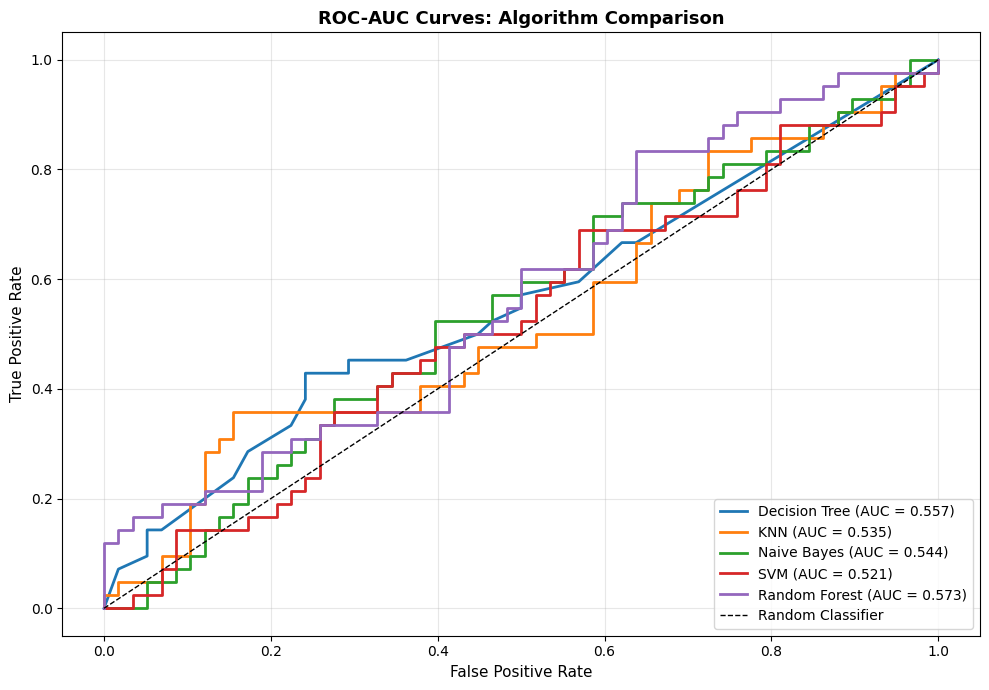

In [ ]:
# ===================================================================
# SECTION 3.5: ROC-AUC CURVES
# ===================================================================

fig, ax = plt.subplots(figsize=(10, 7))

models_roc = [
    (dt_best, X_test, "Decision Tree"),
    (knn_best, X_test_scaled, "KNN"),
    (nb_model, X_test, "Naive Bayes"),
    (svm_best, X_test_scaled, "SVM"),
    (rf_best, X_test, "Random Forest"),
]

for model, X_test_data, label in models_roc:
    y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})', linewidth=2)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC-AUC Curves: Algorithm Comparison', fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





FEATURE IMPORTANCE ANALYSIS (Lecture 6: Feature Reduction)

Top 10 Most Important Features (Random Forest):
             Feature  Importance
              Rating    0.154011
      Season_encoded    0.114628
       Style_encoded    0.105416
SleeveLength_encoded    0.092091
    Material_encoded    0.091242
    NeckLine_encoded    0.081741
  Decoration_encoded    0.077412
        Size_encoded    0.073783
       Price_encoded    0.071176
Pattern Type_encoded    0.061547


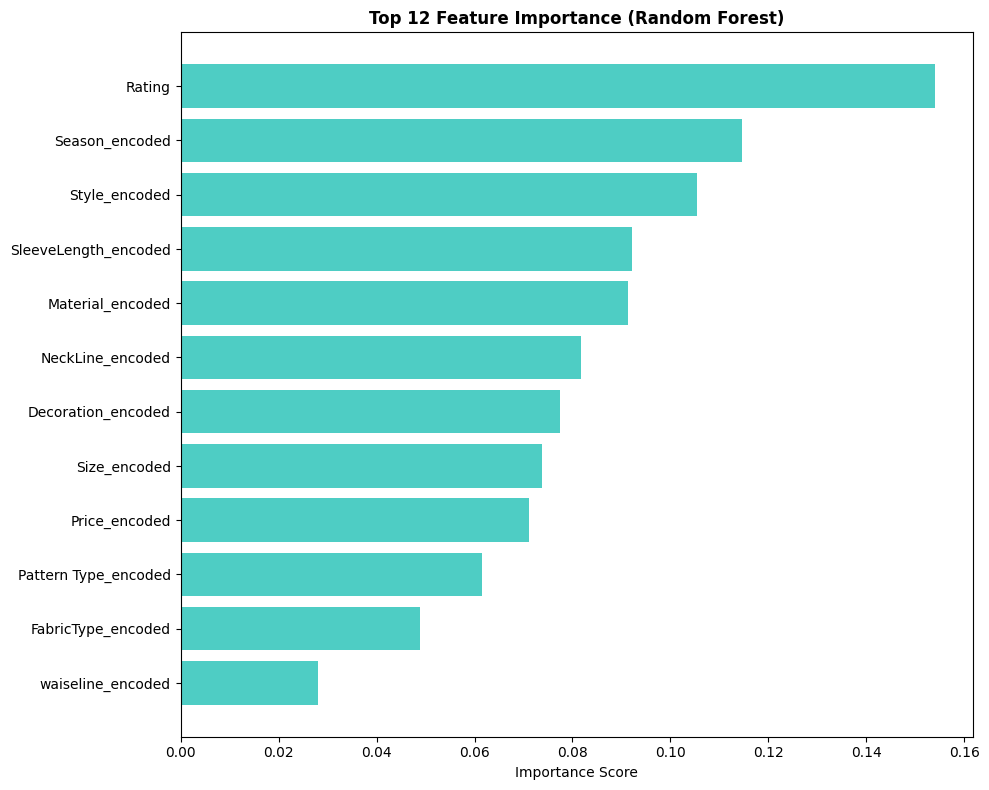

In [ ]:
## SECTION 4: ANALYSIS & INSIGHTS

# ===================================================================
# SECTION 4.1: FEATURE IMPORTANCE ANALYSIS (Lecture 6)
# ===================================================================
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS (Lecture 6: Feature Reduction)")
print("="*70)

# Random Forest Feature Importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_df.head(10).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance_df.head(12)
ax.barh(range(len(top_features)), top_features['Importance'].values, color='#4ECDC4')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Importance Score')
ax.set_title('Top 12 Feature Importance (Random Forest)', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()




CROSS-VALIDATION ANALYSIS (5-Fold)

Decision Tree:
  CV Scores: [0.60526316 0.53731343 0.46376812 0.45238095 0.51948052]
  Mean CV F1: 0.5156 (+/- 0.0552)

KNN:
  CV Scores: [0.5        0.43333333 0.59016393 0.38095238 0.33898305]
  Mean CV F1: 0.4487 (+/- 0.0889)

Naive Bayes:
  CV Scores: [0.33962264 0.47272727 0.37735849 0.2745098  0.39285714]
  Mean CV F1: 0.3714 (+/- 0.0651)

SVM:
  CV Scores: [0.59459459 0.64864865 0.64102564 0.46575342 0.43835616]
  Mean CV F1: 0.5577 (+/- 0.0886)

Random Forest:
  CV Scores: [0.60869565 0.44827586 0.55737705 0.51515152 0.45901639]
  Mean CV F1: 0.5177 (+/- 0.0602)


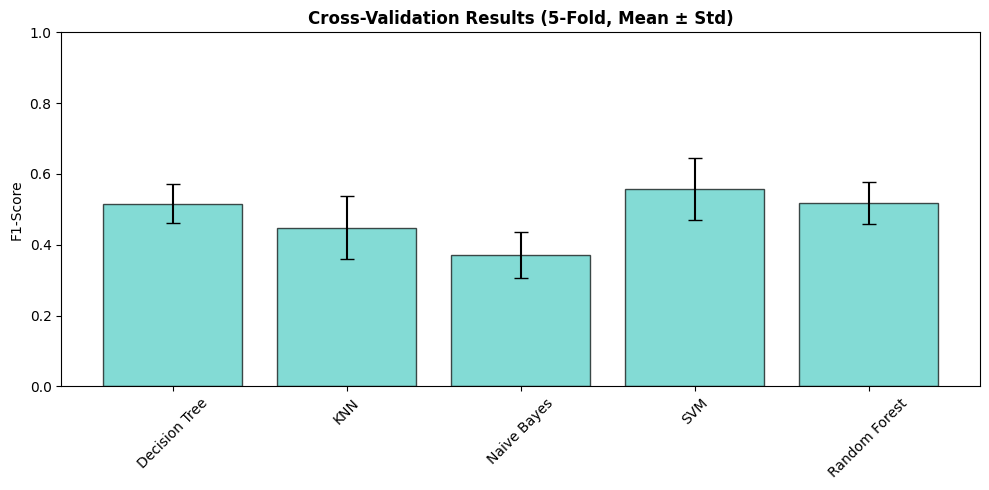

In [ ]:
# ===================================================================
# SECTION 4.2: CROSS-VALIDATION ANALYSIS
# ===================================================================
print("\n" + "="*70)
print("CROSS-VALIDATION ANALYSIS (5-Fold)")
print("="*70)

cv_models = {
    'Decision Tree': dt_best,
    'KNN': knn_best,
    'Naive Bayes': nb_model,
    'SVM': svm_best,
    'Random Forest': rf_best,
}

cv_results = {}
for name, model in cv_models.items():
    # Use scaled features for KNN and SVM
    X_cv = X_train_scaled if name in ['KNN', 'SVM'] else X_train
    cv_scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='f1')
    cv_results[name] = cv_scores
    print(f"\n{name}:")
    print(f"  CV Scores: {cv_scores}")
    print(f"  Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 5))
cv_means = [cv_results[m].mean() for m in cv_models.keys()]
cv_stds = [cv_results[m].std() for m in cv_models.keys()]

x_pos = np.arange(len(cv_models))
ax.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, color='#4ECDC4', alpha=0.7, edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(cv_models.keys(), rotation=45)
ax.set_ylabel('F1-Score')
ax.set_title('Cross-Validation Results (5-Fold, Mean ± Std)', fontweight='bold')
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
## SECTION 5: PROFESSIONAL SUMMARY TABLE

# ===================================================================
# SECTION 5: COMPREHENSIVE RESULTS SUMMARY
# ===================================================================

print("\n" + "="*70)
print("COMPREHENSIVE MODEL EVALUATION SUMMARY")
print("="*70)

summary_table = evaluation_df[['Model', 'Accuracy', 'Precision', 'Recall',
                              'Sensitivity', 'Specificity', 'F1-Score', 'ROC-AUC']].round(4)

print("\n" + summary_table.to_string(index=False))

# Best models by metric
print("\n" + "="*70)
print("BEST MODELS BY METRIC")
print("="*70)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_model_idx = evaluation_df[metric].idxmax()
    best_model = evaluation_df.loc[best_model_idx]
    print(f"{metric}: {best_model['Model']} ({best_model[metric]:.4f})")

# Overall recommendation
print("\n" + "="*70)
print("RECOMMENDATION FOR PRODUCTION")
print("="*70)
best_f1_idx = evaluation_df['F1-Score'].idxmax()
best_model_rec = evaluation_df.loc[best_f1_idx]
print(f"Recommended Model: {best_model_rec['Model']}")
print(f"F1-Score: {best_model_rec['F1-Score']:.4f}")
print(f"ROC-AUC: {best_model_rec['ROC-AUC']:.4f}")
print(f"Precision: {best_model_rec['Precision']:.4f}")
print(f"Recall: {best_model_rec['Recall']:.4f}")




COMPREHENSIVE MODEL EVALUATION SUMMARY

                Model  Accuracy  Precision  Recall  Sensitivity  Specificity  F1-Score  ROC-AUC
        Decision Tree      0.53     0.4468  0.5000       0.5000       0.5517    0.4719   0.5569
                  KNN      0.53     0.4359  0.4048       0.4048       0.6207    0.4198   0.5353
          Naive Bayes      0.56     0.4615  0.2857       0.2857       0.7586    0.3529   0.5435
                  SVM      0.52     0.4483  0.6190       0.6190       0.4483    0.5200   0.5205
        Random Forest      0.54     0.4375  0.3333       0.3333       0.6897    0.3784   0.5735
Decision Tree (SMOTE)      0.58     0.5000  0.5000       0.5000       0.6379    0.5000   0.5920
Random Forest (SMOTE)      0.56     0.4706  0.3810       0.3810       0.6897    0.4211   0.5690

BEST MODELS BY METRIC
Accuracy: Decision Tree (SMOTE) (0.5800)
Precision: Decision Tree (SMOTE) (0.5000)
Recall: SVM (0.6190)
F1-Score: SVM (0.5200)

RECOMMENDATION FOR PRODUCTION
Recommende